In [2]:
import os
import numpy as np
import pandas
from natsort import natsorted
from glob import glob
import math
import geopandas as gpd

import re
import fiona
import rasterio
from rasterio.mask import mask
from rasterio import warp
from rasterio.warp import transform_geom
from rasterio.enums import Resampling
from pyproj import CRS

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

In [3]:
def get_mobility_rivers(paths, river, mob_storage):
    """
    Processes mobility metrics for each reach of a specified river and saves
    the results to separate CSV files with the reach number in the filename.

    Parameters:
        paths (dict): Dictionary of file paths with "reach_x" keys (where x is the reach number).
        river (str): Name of the river.
        mob_storage (str): Path to store the output CSV files.

    Returns:
        str: Name of the river (for confirmation or chaining).
    """
    # Ensure the storage directory exists
    if not os.path.exists(mob_storage):
        os.makedirs(mob_storage)
    
    print(f"Processing river: {river}")
    
    # Iterate through each reach's file paths
    for reach_key, path_list in paths.items():
        # Extract the reach number from the reach_key (assumes format "reach_x")
        reach_number = reach_key.split('_')[1]  # Gets the 'x' part of "reach_x"

        # Sort paths naturally
        path_list = natsorted(path_list)

        # Generate the mask for the reach
        mask = create_mask_shape(river, path_list)

        # Clean and retrieve images and metadata
        images, metas = clean(river, path_list)

        # Set a fixed scale for processing
        scale = 30

        # Calculate yearly mobility metrics
        river_dfs = get_mobility_yearly(images, mask, scale=scale)

        # Combine data into a full DataFrame for the reach
        full_df = pandas.DataFrame()
        for year, df in river_dfs.items():
            rnge = f"{year}_{df.iloc[-1]['year']}"
            df['dt'] = pandas.to_datetime(df['year'], format='%Y')
            df['range'] = rnge

            # Append data to the final DataFrame
            full_df = pandas.concat([full_df, df], ignore_index=True)

        # Define the output path with reach number in the filename
        out_path = os.path.join(mob_storage, river, f'{river}_reach_{reach_number}_yearly_mobility.csv')
        full_df.to_csv(out_path, index=False)
        print(f"Saved mobility metrics for {river} reach {reach_number} to {out_path}")

    return river  # Returning river as a simple confirmation


def get_mobility_yearly(images, mask, scale=30):

    A = len(np.where(mask == 1)[1])

    year_range = list(images.keys())
    ranges = [year_range[i:] for i, yr in enumerate(year_range)]
    river_dfs = {}
    for yrange in ranges:
        data = {
            'year': [],
            'i': [],
            'O_avg': [],
            'O_wd': [],
            'O_dw': [],
            'O_wick': [],
            'fR': [],
            'fR_wick': [],
            'w_b': [],
            'd_b': [],
        }
        length = images[yrange[0]].shape[0]
        width = images[yrange[0]].shape[1]
        long = len(yrange)
        all_images = np.empty((length, width, long))
        years = []
        for j, year in enumerate(yrange):
            years.append(year)
            im = images[str(year)].astype(int)
            filt = np.where(~np.array(mask) + 2)
            im[filt] = 0
            all_images[:, :, j] = im

        baseline = all_images[:, :, 0]
        w_b = len(np.where(baseline == 1)[0])
        fb = mask - baseline
        fw_b = w_b / A
        fd_b = np.sum(fb) / A
        Na = A * fd_b

        for j in range(all_images.shape[2]):
            im = all_images[:, :, j]

            kb = (
                np.sum(all_images[:, :, :j + 1], axis=(2))
                + mask
            )
            kb[np.where(kb != 1)] = 0
            Nb = np.sum(kb)
            # fR = (Na / w_b) - (Nb / w_b)
            fR = (Na - Nb)
            fR_wick = 1 - (Nb / Na)

            # Calculate D - EQ. (1)
            D = np.subtract(baseline, im)
            # 1 - wet -> dry
            d_wd = len((np.where(D == 1))[0])
            # -1 - dry -> wet
            d_dw = len((np.where(D == -1))[0])

            # Calculate Phi
            w_t = len(np.where(im == 1)[0])
            fw_t = w_t / A
            fd_t = (A - w_t) / A

            # Calculate O_Phi
            PHI = (fw_b * fd_t) + (fd_b * fw_t)
            o_wick = 1 - (np.sum(np.abs(D)) / (A * PHI))
            o_avg = w_b - np.mean([d_wd, d_dw])
            o_wd = w_b - d_wd
            o_dw = w_b - d_dw

            data['i'].append(j)
            data['O_avg'].append(o_avg * (scale**2))
            data['O_wd'].append(o_wd * (scale**2))
            data['O_dw'].append(o_dw * (scale**2))
            data['O_wick'].append(o_wick)
            data['fR'].append(fR * (scale**2))
            data['fR_wick'].append(fR_wick)
            data['w_b'].append(w_b * (scale**2))
            data['d_b'].append(Na * (scale**2))

        data['year'] = years
        data['i'] = np.array(years).astype(int) - int(years[0])
        river_dfs[yrange[0]] = pandas.DataFrame(data=data)

    return river_dfs

In [4]:
def generate_paths_dict(river, folder_path):
    """
    Generates a dictionary of paths where each key is the reach (identified by subfolder name),
    and the values are lists of .tif files corresponding to that reach.
    
    Parameters:
    river (str): The river name (used as a subfolder name).
    folder_path (str): The root directory that contains subfolders for each reach.
    
    Returns:
    dict: A dictionary where each key is a reach (ds_order), and values are lists of .tif files.
    """
    paths = {}
    # Define the base folder for the river
    river_folder = os.path.join(folder_path, river)
    
    # Iterate over each reach folder (assumed to be named as the ds_order of each reach)
    for reach_folder in os.listdir(river_folder):
        reach_path = os.path.join(river_folder, reach_folder, 'Cleaned')
        
        # Check if the directory exists and contains .tif files
        if os.path.isdir(reach_path):
            tif_files = glob(os.path.join(reach_path, "*.tif"))
            if tif_files:
                paths[reach_folder] = tif_files
    
    return paths

In [7]:
paths = generate_paths_dict(r'Beni', r'D:\Dissertation\Data\RiverMapping\RiverMasks')


In [12]:
def create_mask_shape(river, fps):
    """
    Reads the first raster file in fps and applies a mask processing step to return a binary raster
    where pixel values are transformed as follows:
        - Values < 10 are set to 0
        - Values >= 10 are set to 1

    Parameters:
    river (str): Unused in this version, kept for consistency with the original function signature.
    fps (list): List of file paths to raster images, with the first path being used for processing.

    Returns:
    numpy.ndarray: A 2D array with the processed binary mask.
    """
    import rasterio
    import numpy as np

    # Use the first file path in fps to open the raster file
    image = fps[0]
    with rasterio.open(image) as ds:
        # Read the data as a 2D array (assuming single-band raster)
        out_image = ds.read(1).astype('int64')
        
        # Mask processing
        out_image += 11  # Offset values as in the original function
        out_image[np.where(out_image < 10)] = 0
        out_image[np.where(out_image > 10)] = 1

    return out_image

def clean(river, fps):
    """
    Processes a set of raster images by creating binary water masks without using any polygon for masking.
    Each raster file in `fps` is read, transformed into a binary water mask, and stored in a dictionary
    by year (derived from filenames).

    Parameters:
    river (str): Unused in this version, kept for compatibility with the original function signature.
    fps (list): List of file paths to raster images.

    Returns:
    tuple: A dictionary of images (binary masks by year) and their respective metadata.
    """

    images = {}
    metas = {}

    # Process each file path in fps
    for fp in fps:
        # Extract year from filename using regex
        year_match = re.findall(r"[0-9]{4,7}", fp)
        if year_match:
            year = year_match[-1]  # Take the last match as the year
        else:
            continue  # Skip files without a year identifier
        
        # Open the raster file
        with rasterio.open(fp) as ds:
            # Read the data and apply threshold to create a binary water mask
            image = ds.read(1, resampling=Resampling.nearest) > 0  # Binary mask where pixel > 0 is water
            
            # Skip images with no water (all values are 0)
            if not np.any(image):
                continue
            
            # Update metadata for the binary water mask
            meta = ds.meta
            meta.update(
                width=image.shape[1],
                height=image.shape[0],
                count=1,
                dtype=rasterio.int8
            )
            
            # Save the binary water mask and its metadata
            images[year] = image
            metas[year] = meta

    return images, metas





In [13]:
test = get_mobility_rivers(paths, 'Beni', r'C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Mobility\Mobility_DFs')

Processing river: Beni
Saved mobility metrics for Beni reach 38 to C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Mobility\Mobility_DFs\Beni\Beni_reach_38_yearly_mobility.csv
Saved mobility metrics for Beni reach 37 to C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Mobility\Mobility_DFs\Beni\Beni_reach_37_yearly_mobility.csv
Saved mobility metrics for Beni reach 36 to C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Mobility\Mobility_DFs\Beni\Beni_reach_36_yearly_mobility.csv
Saved mobility metrics for Beni reach 35 to C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Mobility\Mobility_DFs\Beni\Beni_reach_35_yearly_mobility.csv
Saved mobility metrics for Beni reach 34 to C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Mobility\Mobility_DFs\Beni\Beni_reach_34_yearly_mobility.csv


KeyboardInterrupt: 

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_metric_and_plot(csv_path):
    """
    Calculate a metric 'fr_over_w_b' from the input CSV and plot the median value at each i value,
    with uncertainty bars representing the interquartile range (IQR).

    Parameters:
    csv_path (str): Path to the input CSV file.

    Returns:
    None
    """
    try:
        # Load the data
        data = pd.read_csv(csv_path)

        # Normalize fR by w_b for each sequence
        data['fr_over_w_b'] = data['fR'] / data['w_b']

        # Group by 'i' and calculate median and IQR for fr_over_w_b
        grouped = data.groupby('i')['fr_over_w_b'].agg(
            median='median',
            q1=lambda x: x.quantile(0.25),
            q3=lambda x: x.quantile(0.75)
        ).reset_index()

        # Calculate interquartile range (IQR)
        grouped['iqr'] = grouped['q3'] - grouped['q1']

        # Plot median fr_over_w_b with uncertainty bars
        plt.figure(figsize=(10, 6))
        plt.errorbar(
            grouped['i'], grouped['median'], 
            yerr=[grouped['median'] - grouped['q1'], grouped['q3'] - grouped['median']], 
            fmt='o-', capsize=5, label='Median fr_over_w_b with IQR'
        )
        plt.xlabel('Time Index (i)')
        plt.ylabel('Normalized Reworked Pixels (fr_over_w_b)')
        plt.title('Median Normalized Reworked Pixels (fr_over_w_b) Over Time with IQR')
        plt.grid(True)
        plt.legend()
        plt.show()

    except FileNotFoundError:
        raise FileNotFoundError(f"The file at {csv_path} could not be found.")
    except KeyError as e:
        raise KeyError(f"Missing expected column in the dataset: {e}")
    except Exception as e:
        raise Exception(f"An error occurred while processing the file: {e}")

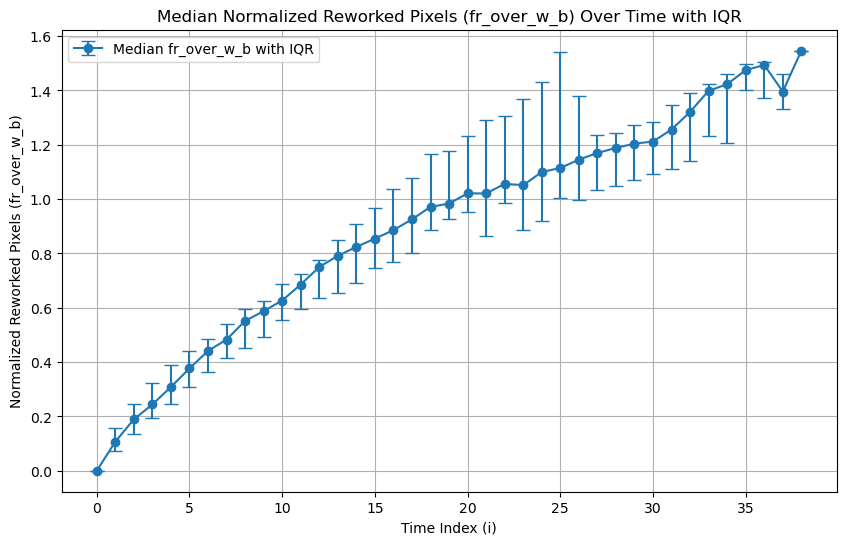

None


In [24]:
# Example function usage (commented out to avoid execution here)
metric = calculate_metric_and_plot(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Mobility\Mobility_DFs\Beni\Beni_reach_12_yearly_mobility.csv")
print(metric)

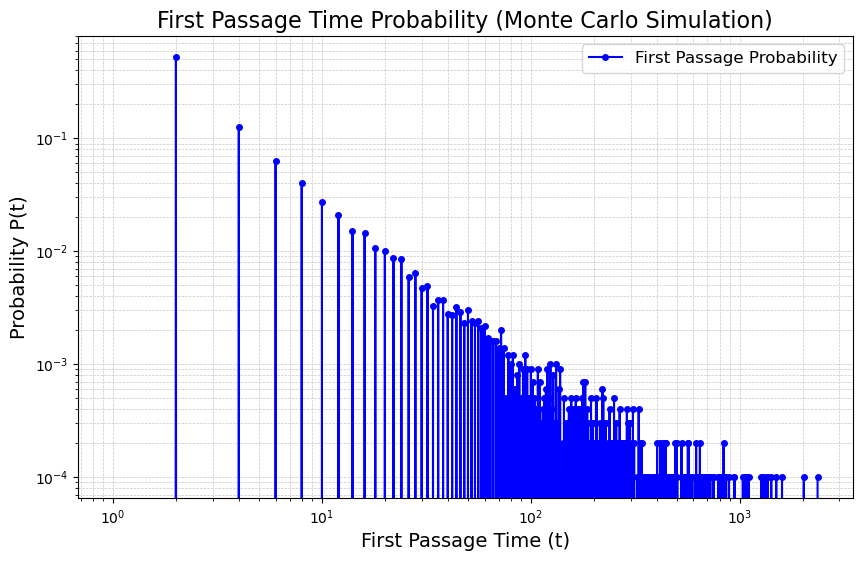

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
B = 10       # Boundary distance
L = 1        # Step length
N = 10000    # Number of iterations

# Monte Carlo Simulation
first_passage_times = []

for _ in range(N):
    # Initialize random starting position
    x0 = np.random.randint(-B, B + 1) * L
    x = x0
    t = 0
    
    # Random walk until returning to the starting position
    while True:
        t += 1
        step = L if np.random.rand() < 0.5 else -L
        x += step
        
        # Reflecting boundary conditions
        if x > B:
            x = B - L
        elif x < -B:
            x = -B + L
        
        # Check if returned to starting position
        if x == x0:
            first_passage_times.append(t)
            break

# Compute First Passage Probability
max_t = max(first_passage_times)
hist, bins = np.histogram(first_passage_times, bins=range(1, max_t + 2), density=True)
t_values = bins[:-1]  # Time values corresponding to histogram bins

# Plot on a logarithmic scale
plt.figure(figsize=(10, 6))
plt.loglog(t_values, hist, color='blue', marker='o', markersize=4, linewidth=1.5, label='First Passage Probability')

# Labels and Title
plt.xlabel('First Passage Time (t)', fontsize=14)
plt.ylabel('Probability P(t)', fontsize=14)
plt.title('First Passage Time Probability (Monte Carlo Simulation)', fontsize=16)
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12)

# Show plot
plt.show()


In [3]:
def calculate_median_fit_with_TR_and_uncertainty(csv_file):
    # Load the data from the CSV file
    data = pandas.read_csv(csv_file)
    
    # Calculate AR_over_AW as fR / w_b
    data['AR_over_AW'] = data['fR'] / data['w_b']
    
    # Group by 'i' and calculate the median and confidence intervals for each 'i'
    grouped = data.groupby('i')
    
    # Lists to store the median, lower and upper confidence intervals, and i values
    median_values = []
    lower_ci = []
    upper_ci = []
    i_values = []
    
    for i, group in grouped:
        i_values.append(i)
        median_ar_over_aw = np.median(group['AR_over_AW'])
        median_values.append(median_ar_over_aw)
        
        # Calculate the 95% confidence interval for the current group
        ci_bounds = np.percentile(group['AR_over_AW'], [2.5, 97.5])
        lower_ci.append(ci_bounds[0])
        upper_ci.append(ci_bounds[1])
    
    # Convert to numpy arrays for further processing
    i_values = np.array(i_values)
    median_values = np.array(median_values)
    lower_ci = np.array(lower_ci)
    upper_ci = np.array(upper_ci)
    
    # Define the exponential decay model with asymptote
    def exp_decay_asymptote(i, PR_over_AW, CR):
        return - PR_over_AW * np.exp(-CR * i) + PR_over_AW
    
    # Initial guess for PR_over_AW and CR
    initial_guess = [1, 0.1]
    
    # Fit the model to the median values
    params, covariance = curve_fit(exp_decay_asymptote, i_values, median_values, p0=initial_guess)
    
    # Extract parameters PR_over_AW and CR
    PR_over_AW, CR = params
    
    # Generate fitted values for plotting
    i_fit = np.linspace(min(i_values), max(i_values), 100)
    y_fit_asymptote = exp_decay_asymptote(i_fit, PR_over_AW, CR)
    
    # Calculate TR
    PR = PR_over_AW  # Assuming Aw = 1 for simplicity in this case
    Aw = 1  # You can change Aw if needed
    TR = (1 / CR) * (Aw / PR)
    
    # Plot the median data points with uncertainty bars
    plt.errorbar(i_values, median_values, yerr=[median_values - lower_ci, upper_ci - median_values], 
                 fmt='o', label='Median area reworked', color='red', ecolor='gray', capsize=5)
    
    # Plot the fitted curve
    plt.plot(i_fit, y_fit_asymptote, label=f'Fit: y = -({PR_over_AW:.4f}) * exp(-{CR:.4f} * i) + ({PR_over_AW:.4f})', color='blue')
    
    # Plot TR as a diagonal line from (0, 0) to (TR, 1)
    x_tr_line = np.linspace(0, TR, 100)
    y_tr_line = x_tr_line / TR  # A diagonal line with slope = 1/TR
    plt.plot(x_tr_line, y_tr_line, label=f'TR = {TR:.4f} years', color='green', linestyle='--')
    
    # Labels and title
    plt.xlabel("Time")
    plt.ylabel("Normalized cumulative area reworked")
    plt.title("")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print PR, CR, and TR values
    print(f"PR = {PR_over_AW:.4f}, CR = {CR:.4f}, TR = {TR:.4f}")
    
    # Return the fitted equation and parameters
    return f"Fitted equation: y = -({PR_over_AW:.4f}) * exp(-{CR:.4f} * i) + ({PR_over_AW:.4f}), TR = {TR:.4f}"

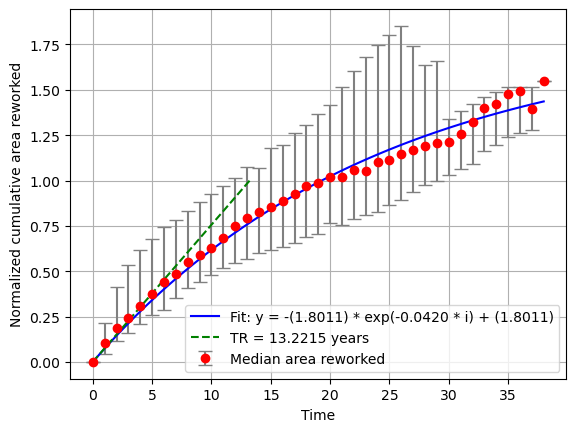

PR = 1.8011, CR = 0.0420, TR = 13.2215


'Fitted equation: y = -(1.8011) * exp(-0.0420 * i) + (1.8011), TR = 13.2215'

In [4]:
# Example usage
calculate_median_fit_with_TR_and_uncertainty(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Mobility\Mobility_DFs\Beni\Beni_reach_12_yearly_mobility.csv")

In [9]:
calculate_median_fit_with_TR_and_uncertainty(r"D:\Dissertation\Data\RiverMapping\RiverMasks\Brahmaputra\25\Brahmaputra_reach_25_yearly_mobility.csv")

NameError: name 'curve_fit' is not defined

In [ ]:
calculate_median_fit_with_TR_and_uncertainty(r"D:\Dissertation\Data\RiverMapping\RiverMasks\Bermejo\35\Bermejo_reach_35_yearly_mobility.csv")


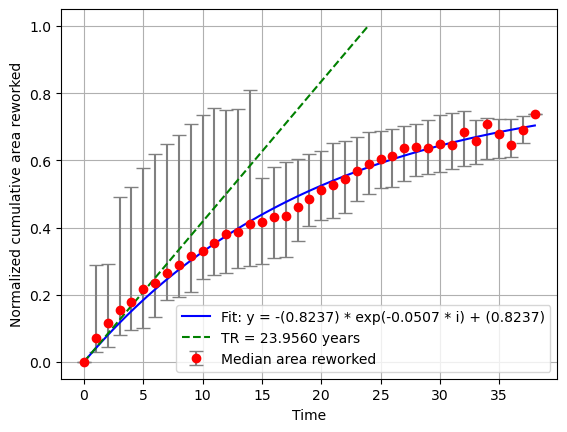

PR = 0.8237, CR = 0.0507, TR = 23.9560


'Fitted equation: y = -(0.8237) * exp(-0.0507 * i) + (0.8237), TR = 23.9560'

In [12]:
calculate_median_fit_with_TR_and_uncertainty(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Mobility\Mobility_DFs\Bermejo\Bermejo_reach_35_yearly_mobility.csv")

In [13]:
print(shapefile_path)

C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Reaches


In [16]:
gdf = gpd.read_file(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Reaches\Bermejo\Bermejo.shp")  # Load the full shapefile
reach_35 = gdf[gdf['ds_order'] == 35]  # Filter to reach 33
print(reach_35)  # Print reach 33 info

   ds_order  reach_len     ds_dist  bufwid_m      bufar_m2  \
0        35   35712.08  1013186.08  5356.812  4.472657e+08   

                                            geometry  
0  POLYGON ((-6572062.103 -3022781.761, -6571690....  


In [21]:
gdf = gpd.read_file(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Reaches\Bermejo\Bermejo.shp")

In [24]:
tif_path = r"D:\Dissertation\Data\RiverMapping\RiverMasks\Bermejo\reach_35\Cleaned\Bermejo_reach_35_1986_DSWE_level_3_cleaned.tif"
ds = rasterio.open(r"D:\Dissertation\Data\RiverMapping\RiverMasks\Bermejo\reach_35\Cleaned\Bermejo_reach_35_1986_DSWE_level_3_cleaned.tif")

In [25]:
print(f"Shapefile CRS: {gdf.crs}")
print(f"Raster CRS: {ds.crs}")

Shapefile CRS: PROJCS["WGS_84_World_Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mercator_2SP"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Raster CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]


In [28]:
with rasterio.open(tif_path) as dataset:
    # Read the first band of the raster
    raster_data = dataset.read(1)

    # Count the number of pixels with a value of 1
    count_ones = np.sum(raster_data == 1)

print(f"Number of pixels with a value of 1: {count_ones}")

Number of pixels with a value of 1: 6234


In [17]:
print(f"Shapefile CRS: {gdf.crs}")

Shapefile CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]


In [11]:

gdf = gpd.read_file(polygon_path)

# Open the first raster in fps to get its CRS
image = fps[0]
ds = rasterio.open(image)
    
# Print CRS information for debugging
print(f"Shapefile CRS: {gdf.crs}")
print(f"Raster CRS: {ds.crs}")
    
# Reproject the shapefile to match the raster's CRS if necessary
if gdf.crs != ds.crs:
    gdf = gdf.to_crs(ds.crs)
    print("Reprojected shapefile to match raster CRS")

# Proceed with masking
geometries = gdf.geometry
for geom in geometries:
    geom_transformed = transform_geom(
        src_crs=gdf.crs,
        dst_crs=ds.crs,
        geom=geom.__geo_interface__,
    )
    out_image, out_transform = mask(
        ds, [geom_transformed],
        crop=False, filled=False
    )
    out_image = out_image.astype('int64')
    out_image[np.where(out_image < 10)] = 0
    out_image[np.where(out_image > 10)] = 1

    return out_image[0, :, :]

No EPSG code available for this CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]


In [4]:
import os
import numpy as np
import rasterio
import pandas as pd

In [5]:
def calculate_mean_classification_area(parent_dir, river_name):
    results = []

    # Construct the full river path
    river_path = os.path.join(parent_dir, river_name)

    # Loop through each reach subfolder in the river path
    for reach_folder in os.listdir(river_path):
        reach_path = os.path.join(river_path, reach_folder, 'Cleaned')
        
        # Check if the 'Cleaned' folder exists in the reach folder
        if os.path.isdir(reach_path):
            total_zeros = 0
            total_ones = 0
            raster_count = 0
            
            # Loop through each raster file in the 'Cleaned' folder
            for filename in os.listdir(reach_path):
                file_path = os.path.join(reach_path, filename)
                
                # Process only raster files (assuming .tif format)
                if filename.endswith('.tif'):
                    with rasterio.open(file_path) as raster:
                        data = raster.read(1)  # Read the first band
                        
                        # Count pixels classified as 0 and 1
                        zero_count = np.sum(data == 0)
                        one_count = np.sum(data == 1)
                        
                        # Accumulate counts
                        total_zeros += zero_count
                        total_ones += one_count
                        raster_count += 1
            
            # Calculate average pixel counts and convert to area (m^2)
            if raster_count > 0:
                avg_zeros_area = (total_zeros / raster_count) * (30 ** 2)
                avg_ones_area = (total_ones / raster_count) * (30 ** 2)
            else:
                avg_zeros_area, avg_ones_area = 0, 0
            
            # Append the result for the reach
            results.append({
                'Reach': reach_folder,
                'Average_Area_0_m2': avg_zeros_area,
                'Average_Area_1_m2': avg_ones_area
            })

    # Convert results to a DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    csv_path = os.path.join(parent_dir, f"{river_name}_mean_classification_areas.csv")
    results_df.to_csv(csv_path, index=False)
    print(f"Results saved to {csv_path}")

In [6]:
parent_directory = r"D:\Dissertation\Data\RiverMapping\RiverMasks"
river_name = "Beni"
calculate_mean_classification_area(parent_directory, river_name)

Results saved to D:\Dissertation\Data\RiverMapping\RiverMasks\Beni_mean_classification_areas.csv


In [52]:
import geopandas as gpd
import pandas as pd

def calculate_lengths(shapefile_path, output_excel_path):
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Ensure the CRS is projected for accurate length calculations
    if gdf.crs.is_geographic:
        # Convert to a projected CRS (e.g., UTM zone covering the region)
        gdf = gdf.to_crs(epsg=32620)  # UTM Zone 20S, adjust as needed for your region
    
    # Calculate lengths in kilometers
    gdf['length_km'] = gdf.length / 1000  # Convert from meters to kilometers
    
    # Extract the ds_order and calculated lengths
    lengths_df = gdf[['ds_order', 'length_km']]
    
    # Group by ds_order if multiple geometries share the same order and sum lengths
    result_df = lengths_df.groupby('ds_order').sum().reset_index()
    
    # Save to Excel
    result_df.to_excel(output_excel_path, index=False)
    print(f"Results saved to {output_excel_path}")

# Example usage
shapefile_path = r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\HydroATLAS\HydroRIVERS\Extracted_Rivers\Bermejo\Bermejo_reaches.shp"
output_excel_path = r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\HydroATLAS\HydroRIVERS\Extracted_Rivers\Bermejo\line_lengths_by_ds_order.xlsx"
calculate_lengths(shapefile_path, output_excel_path)

Results saved to C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\HydroATLAS\HydroRIVERS\Extracted_Rivers\Bermejo\line_lengths_by_ds_order.xlsx


In [53]:
import geopandas as gpd
import pandas as pd

def calculate_channel_belt_area_by_reach(reach_shapefile, channel_belt_shapefile, output_csv):
    # Load the reach and channel belt shapefiles
    reaches_gdf = gpd.read_file(reach_shapefile)
    channel_belt_gdf = gpd.read_file(channel_belt_shapefile)
    
    # Ensure both layers are in the same CRS
    if reaches_gdf.crs != channel_belt_gdf.crs:
        channel_belt_gdf = channel_belt_gdf.to_crs(reaches_gdf.crs)
    
    # Extract the single channel belt polygon
    channel_belt_polygon = channel_belt_gdf.geometry.iloc[0]
    
    # Initialize an empty list to store results
    results = []
    
    # Loop through each reach polygon and calculate the intersection area
    for _, reach in reaches_gdf.iterrows():
        reach_id = reach['ds_order']
        
        # Calculate the intersection between reach and channel belt
        intersection = reach.geometry.intersection(channel_belt_polygon)
        
        # Calculate the area of the intersection in square kilometers
        if not intersection.is_empty:
            area_km2 = intersection.area / 1e6  # Convert from square meters to square kilometers
        else:
            area_km2 = 0  # No intersection
        
        # Append the results
        results.append({
            'ds_order': reach_id,
            'channel_belt_area_km2': area_km2
        })
    
    # Convert the results to a DataFrame and save as CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")

# Example usage
reach_shapefile = r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Reaches\Bermejo\Bermejo.shp"
channel_belt_shapefile = r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\ChannelBelts\Bermejo\Bermejo_ChannelBelt.shp"
output_csv = r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\ChannelBelts\Bermejo\Bermejo_channel_belt_area_by_reach.csv"
calculate_channel_belt_area_by_reach(reach_shapefile, channel_belt_shapefile, output_csv)

Results saved to C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\ChannelBelts\Bermejo\Bermejo_channel_belt_area_by_reach.csv


In [29]:
import os
import re
from PIL import Image, ImageDraw, ImageFont
import imageio.v2 as imageio

# Define the folder and output paths
folder_path = r"D:\Dissertation\Data\RiverMapping\RiverMasks\Brahmaputra\reach_1\Processed"
output_path = r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\Code\Troubleshooting\timelapse.gif"

# Regex pattern to match the year in the filename
pattern = re.compile(r"_([0-9]{4})_")

# Gather and sort the files by year
files = [
    (int(pattern.search(f).group(1)), os.path.join(folder_path, f))
    for f in os.listdir(folder_path)
    if f.endswith(".tif") and pattern.search(f)
]
files.sort()  # Sort by year

# Initialize list for frames
frames = []

# Loop through each .tif file
for year, file_path in files:
    # Open the image as grayscale
    with Image.open(file_path) as img:
        img = img.convert("L")  # Convert to grayscale (1-channel)

        # Invert the colors: map 0s to white (255) and 1s to black (0)
        img = Image.eval(img, lambda x: 255 * (1 - x))  # Inverts 0 and 1 values

        # Draw year as title with increased font size
        draw = ImageDraw.Draw(img)
        title = str(year)

        # Load a larger font size
        try:
            font = ImageFont.truetype("arial.ttf", 48)  # Adjust size as needed
        except IOError:
            font = ImageFont.load_default()  # Fallback if custom font is unavailable

        # Calculate text width and height using textbbox
        text_bbox = draw.textbbox((0, 0), title, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]

        # Position the text in the center at the top
        draw.text(((img.width - text_width) / 2, 10), title, font=font, fill="black")

        # Append the frame
        frames.append(img.copy())  # Append a copy to ensure independence of frames

# Save frames as a gif with slower frame rate (quarter speed)
frames[0].save(
    output_path,
    save_all=True,
    append_images=frames[1:],  # Append all frames except the first
    duration=300, 
    loop=0  # Loop indefinitely
)